# DNN paper analysis
Analysis leading to the plots in [Distance-Based Delays in Echo State Networks](https://link.springer.com/chapter/10.1007/978-3-031-21753-1_21).

## Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import populations
from network import tanh_activation
from utils import eval_candidate_lag_gridsearch, createNARMA10
from config import propagation_vel
import pandas as pd
from populations import GMMPopulation, get_empty_GMMpop
sns.set(font="times new roman", style="white", font_scale=2.1)

## Functions
Some helper functions

In [21]:
def NARMA_plot_df_from_evo_dict(dict):
    val_score_mat = dict['validation performance']
    best_scores = []
    for pop in val_score_mat:
        ind_score = []
        for ind in pop:
            best_lag_score = []
            for rep in ind:
                best_lag_score.append(np.min(rep))
            ind_score.append(best_lag_score)
        best_scores.append(ind_score)
    best_scores = np.array(best_scores)
    best_i = np.argmin(np.average(best_scores, axis=-1), axis=-1)
    plot_data_dict = {
        'Generation':[],
        'NRMSE':[]
    }
    for g, i in enumerate(best_i):
        pop = best_scores[g, i, :]
        plot_data_dict['Generation'] += list(np.repeat(g, pop.shape))
        plot_data_dict['NRMSE'] += list(pop)

    plot_df = pd.DataFrame.from_dict(plot_data_dict)
    return plot_df

def get_evolution_info_per_candidate(data, it=99):
    data = data[:it, :, :, :]
    best_lags = np.argmin(data, axis=3)
    performance = np.min(data, axis=3)
    lags_per_cand = np.mean(best_lags, axis=2)
    performance_per_cand = np.mean(performance, axis=2)
    return performance_per_cand, lags_per_cand

def get_evolution_info_per_generation(performance_per_cand, lags_per_cand):
    average_performance = np.mean(performance_per_cand, axis=1)
    best_performance = np.min(performance_per_cand, axis=1)
    average_lag = np.mean(lags_per_cand, axis=1)
    best_lag = np.min(lags_per_cand, axis=1)
    val_per_gen = {'Average performance': average_performance, 'Best performance': best_performance}
    lag_per_gen = {'Average lag': average_lag, 'Best lag': best_lag}
    return val_per_gen, lag_per_gen 

def plot_average_and_best_performance(val_per_gen, ax, title, lab_spac=0):
    ax.plot(val_per_gen['Average performance'])
    ax.plot(val_per_gen['Best performance'])
    ax.set_title(title)
    ax.set_xlabel('Generation')
    ax.set_ylabel('NRMSE')
    ax.legend(['Average of population', 'Best candidate of population'], labelspacing=lab_spac)

def plot_average_and_best_lag(lag_per_gen, ax, title='Average lag per generation', lab_spac=0):
    gens = range(lag_per_gen['Average lag'].shape[0])
    ax.plot(gens, lag_per_gen['Average lag'])
    ax.plot(gens, lag_per_gen['Best lag'])
    ax.set_title(title)
    ax.set_xlabel('Generation')
    ax.set_ylabel('Lag averaged over evaluations')
    ax.legend(['Average of population', 'Best candidate of population'], labelspacing=lab_spac)

def get_scaled_parameter(unscaled, key, net):
    scaled_per_gen = []
    for i in range(unscaled.shape[0]):
        scaled_params = net.get_parameters_from_serialized(unscaled[i, :])
        scaled_p = scaled_params[key]
        
        if scaled_p.shape[0] > 1:
            scaled_p = np.expand_dims(scaled_p, axis=0)
        scaled_per_gen.append(scaled_p)
        
        
    scaled_per_gen = np.concatenate(scaled_per_gen)
    
    return scaled_per_gen

def get_untuned_net(N, k, buffersize=20, activation_func=tanh_activation):
    insize = 1
    outsize = N - insize

    x_range = (0, .002)
    y_range = (0, .004)

    start_mix = np.ones((k,))
    width = x_range[1] - x_range[0]
    height = y_range[1] - y_range[0]
    start_mu = np.zeros((k, 2))
    start_mu[:, :] = (np.mean(x_range) + 0.2 * width, np.mean(y_range) + 0.4 * width)
    start_var = (width) * 0.2
    start_corr = np.ones((k,)) * 0
    start_var = np.random.uniform(start_var, start_var, (k, 2))
    inhib_start = np.ones((k,)) * 0
    in_loc = (x_range[0] + width * 0.3, y_range[0] + height * 0.2)
    
    max_dist = np.sqrt(width**2 + height**2)
    max_delay = max_dist/propagation_vel
    dt = max_delay/(buffersize - 2)
    
    conn_start = np.array(
        [
            [0.25, 0.1],
            [0, 0]
        ]
    )

    cluster_connectivity = np.ones((k + 1, k + 1))
    bias_scaling_start = np.ones((k + 1,)) * 0.5
    weight_scaling_start = np.ones((k + 1, k + 1)) * .5
    decay_start = np.ones((k + 1,)) * .95
    
        
    activation = activation_func
    
    net_params = {
        'N': N,
        'mix': start_mix,
        'mu': start_mu,
        'variance': start_var,
        'correlation': start_corr,
        'inhibitory': inhib_start,
        'connectivity': conn_start,
        'cluster_connectivity': cluster_connectivity,
        'weight_scaling': weight_scaling_start,
        'bias_scaling': bias_scaling_start,
        'x_range': x_range,
        'y_range': y_range,
        'decay': decay_start,
        'size_in': insize,
        'size_out': outsize,
        'in_loc': in_loc,
        'act_func': activation,
        'dt': dt,
        'buffersize': buffersize
    }
    net = populations.GMMPopulationOld(**net_params)
    return net

def plot_lag_info_across_gens(data, ax, gen_step, lab_spac):
    data = np.mean(data, axis=2)
    data = np.mean(data, axis=1)
    nr_gens = data.shape[0]
    gens = np.maximum(0, np.arange(0, nr_gens + 1, gen_step, dtype='int32') - 1)
    print(gens)
    legend = []
    for gen in gens:
        ax.plot(data[gen, :], marker='o')
        legend.append('Generation ' + str(gen))
    ax.set_xlabel('Lag (simulation steps)')
    ax.set_ylabel('NRMSE')
    ax.legend(legend, labelspacing=lab_spac)

## Data import
First, the data paths and additional experiment info (missing from stored data pickles, but necessary for reproduction) is structured in a dict.

In [22]:
# Parameters regarding neuron location and activation function that was not stored in the pickle
x_range = (0, .002)
y_range = (0, .004)
activation_function = tanh_activation
width = x_range[1] - x_range[0]
height = y_range[1] - y_range[0]
in_loc = (x_range[0] + width * 0.3, y_range[0] + height * 0.2)
N = 301

experiment_data = {
    '1K': {
        'DDN':
            {
                'path': 'results-2022-paper/cma_es_gmm_200222k1_tanh_vd_reg.p',
                'N': N,
                'K': 1,
                'B': 20,
                'dt': .000008,
                'x_range': x_range,
                'y_range': y_range,
                'in_loc': in_loc,
                'activation_function': activation_function
            },
        'ESN':
            {
                'path': 'results-2022-paper/cma_es_gmm_250322_k1_tanh_final_paper_bl.p',
                'N': N,
                'K': 1,
                'B': 1,
                'dt': .5,
                'x_range': x_range,
                'y_range': y_range,
                'in_loc': in_loc,
                'activation_function': activation_function
            }
    },
    '4K': {
        'DDN':
            {
                'path': 'results-2022-paper/cma_es_gmm_230222k4_tanh_vd_reg.p',
                'N': N,
                'K': 4,
                'B': 20,
                'dt': .000008,
                'x_range': x_range,
                'y_range': y_range,
                'in_loc': in_loc,
                'activation_function': activation_function
            },
        'ESN':
            {
                'path': 'results-2022-paper/cma_es_gmm_230222k4_tanh_bl_reg.p',
                'N': N,
                'K': 4,
                'B': 1,
                'dt': .5,
                'x_range': x_range,
                'y_range': y_range,
                'in_loc': in_loc,
                'activation_function': activation_function
            }
    }
}

In [23]:
for k_size in experiment_data:
    for net_type in experiment_data[k_size]:
        path = experiment_data[k_size][net_type]['path']
        with open(path, 'rb') as f:
            es_dict = pkl.load(f)
        print(es_dict.keys())
        experiment_data[k_size][net_type]['es_dict'] = es_dict

dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds '])
dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net'])
dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds '])
dict_keys(['validation performance', 'train performance', 'parameters', 'evolutionary strategy', 'cma stds '])


## Evolution Plots
validation score per generation for ESNs (baseline) and DDNs.


First, we process the Generations x Population size x Repetitions x Lag search space validation data matrix

In [24]:
for k_size in experiment_data:
    for net_type in experiment_data[k_size]:
        es_dict = experiment_data[k_size][net_type]['es_dict']
        validation_df = NARMA_plot_df_from_evo_dict(es_dict)
        experiment_data[k_size][net_type]['validation_df'] = validation_df

(0.0, 0.5)

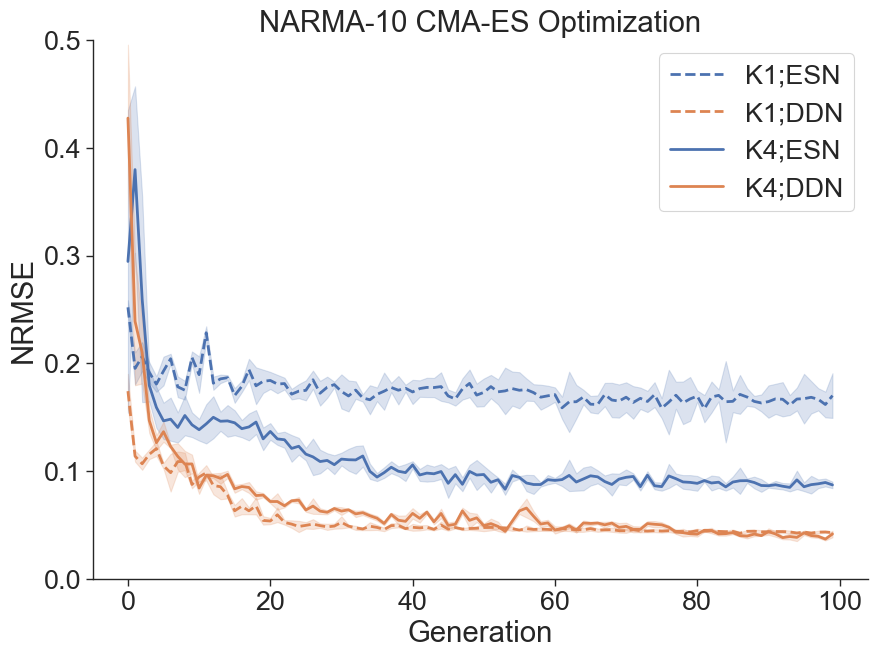

In [25]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=2.2, palette='deep', context='paper', rc=custom_params)

fig, ax= plt.subplots(figsize=(10,7))

sns.lineplot(experiment_data['1K']['ESN']['validation_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C0', linestyle="--", label="K1;ESN", errorbar='sd')
sns.lineplot(experiment_data['1K']['DDN']['validation_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C1', linestyle="--", label="K1;DDN", errorbar='sd')

sns.lineplot(experiment_data['4K']['ESN']['validation_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C0', linestyle="-", label="K4;ESN", errorbar='sd')
sns.lineplot(experiment_data['4K']['DDN']['validation_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C1', linestyle="-", label="K4;DDN", errorbar='sd')

plt.xlabel('Generation')
plt.ylabel('NRMSE')
ax.set_title("NARMA-10 CMA-ES Optimization")
ax.set_ylim(0, 0.5)


## Testing best networks
We select and recreate the best networks and test them on new data

In [26]:
for k_size in experiment_data:
    for net_type in experiment_data[k_size]:
        example_net_parameters = {
            'N': experiment_data[k_size][net_type]['N'],
            'k': experiment_data[k_size][net_type]['K'],
            'dt': experiment_data[k_size][net_type]['dt'],
            'x_range': experiment_data[k_size][net_type]['x_range'],
            'y_range': experiment_data[k_size][net_type]['y_range'],
            'in_loc': experiment_data[k_size][net_type]['in_loc'],
            'activation_function': experiment_data[k_size][net_type]['activation_function'],
            'insize': 1,
            'buffersize': experiment_data[k_size][net_type]['B']
        }

        example_net = get_empty_GMMpop(**example_net_parameters)
        experiment_data[k_size][net_type]['example_net'] = example_net

### Generate Data & train readouts

In [27]:
np.random.seed(42)
data_train_42 = np.array(createNARMA10(20000)).reshape((2, 20000))
data_test_42 = np.array(createNARMA10(10000)).reshape((2, 10000))
np.random.seed()
alphas = [10e-9, 10e-8, 10e-7]

Train and test readouts, save test performances

In [28]:
network_resamples = 40

test_results = {
    '1K': {
        'DDN': [],
        'ESN': []
    },
    '4K': {
        'DDN': [],
        'ESN': []
    }
}

for k_size in experiment_data:
    for net_type in experiment_data[k_size]:
        print('Condition: ' + str(k_size) + ', ' + str(net_type))
        net = experiment_data[k_size][net_type]['example_net']
        best_p = experiment_data[k_size][net_type]['es_dict']['evolutionary strategy'].best.x
        for resample in range(network_resamples):
            print('resample ' + str(resample) + '...')
            best_net = net.get_new_network_from_serialized(best_p)
            print('training readout and testing network...')
            t, v, m = eval_candidate_lag_gridsearch(best_net, data_train_42, data_test_42, warmup=400, alphas=alphas)
            test_results[k_size][net_type].append(v)
            print('score: ' + str(np.min(v)))

save_file = 'results-2022-paper/test_results/best_params.p'
with open(save_file, 'wb') as f:
    pkl.dump(test_results, f)


Condition: 1K, DDN
resample 0...
training readout and testing network...


KeyboardInterrupt: 